**Advance use of RNN**

*   Recurrent Dropout
*   Stacking recurrent Layers

*   Bidirectional recurrent layers


In [4]:
from google.colab import files
files.upload()


Saving jena_climate_2009_2016.csv to jena_climate_2009_2016.csv


In [5]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop


In [ ]:
data_dir = '/content/drive/My Drive/jena_climate_2009_2016.csv'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)', 'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)', 'wd (deg)']
420552


In [6]:
data = pd.read_csv("jena_climate_2009_2016.csv")
print("Shape of data is {}".format(data.shape))
values = data.iloc[:,1:] # excluded date
float_data = np.asarray(values) # converting in numpy array
print("Shape of data without first column is {}".format(float_data.shape))

Shape of data is (420551, 15)
Shape of data without first column is (420551, 14)


In [ ]:
#complete data
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


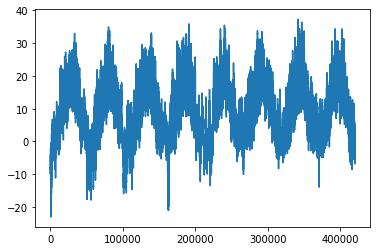

In [ ]:
#plotting temperature timeseries
temp = float_data[:, 1] #<1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

In [ ]:
print(range(len(temp)))

range(0, 420551)


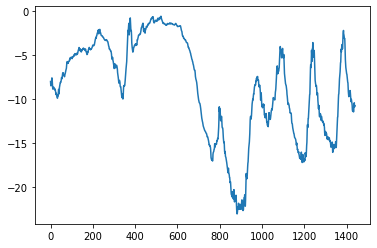

In [ ]:
#plotting data for first 10 days.As data is recorded after 10 mins so we have total of 144 sample points in a day
plt.plot(range(1440),temp[:1440])

Using first 200,000 timesteps for training

In [7]:
#prepairing data 
#scaling data as data has different scales,we need to normalize each Series independently
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [8]:
#Writing a Python Generator  It yields a tuple (samples, targets),where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
#data,lookback,delay,min_index,max_index,shuffle,batch_size,step
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None: 
        max_index = len(data) - delay - 1 
    i = min_index + lookback 
    while 1:
        if shuffle: 
            #Generate random rows
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index: 
                i = min_index + lookback    
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows) # 
        samples = np.zeros((len(rows),lookback // step,data.shape[-1])) 
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets 

In [9]:
#with help of abstract generator function we will instantiate three generators: training,validation and testing
lookback = 1440          #240 sample points
step = 6
delay = 144
batch_size = 128

#first 200,000 time steps for training 
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
#next 100,000 time steps for validation
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
#remaining for test data
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)
# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size
# This is how many steps to draw from `train_gen`
# in order to see the whole train set: 
test_steps = (len(float_data) - 300001 - lookback) // batch_size




Data is ready for modeling

In [8]:
#let's use common sense baseline method to get how much chances are there if today's temp will be same after 24 hours
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:,-1,1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
evaluate_naive_method()

0.28973597299054815


This yields an MAE of 0.29. Because the temperature data has been normalized to be
centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable. It translates to an average absolute error of 0.29 × temperature_std degrees
Celsius: 2.57˚C.

In [ ]:
celsius_mae = 0.3 * std[1]
celsius_mae

2.65574972466139

Base line Simple Machine learning Approach

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 16s 33ms/step - loss: 1.3929 - val_loss: 0.9393
Epoch 2/20
500/500 [==============================] - 16s 32ms/step - loss: 0.4554 - val_loss: 0.3161
Epoch 3/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2982 - val_loss: 0.2632
Epoch 4/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2672 - val_loss: 0.2224
Epoch 5/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2538 - val_loss: 0.2345
Epoch 6/20
500/500 [==============================] - 16s 31ms/step - loss: 0.2430 - val_loss: 0.2987
Epoch 7/20
500/500 [==============================] - 16s 33ms/step - loss: 0.2364 - val_loss: 0.2559
Epoch 8/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2301 - val_loss: 0.2660
Epoch 9/20
500/500 [==============================] - 16s 32ms/step - loss: 0.2245 - val_loss: 0.2971
Epoch 10/20
500/500 [==============================] - 16s 31ms/step - loss: 0.223

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


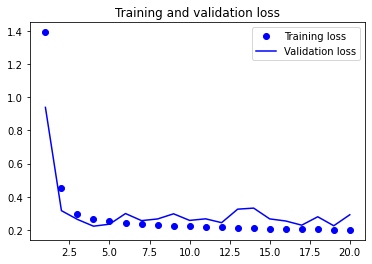

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**A first Recurrent Baseline**

*   Using GRU based model so that to reduce computational complexity  



In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 126s 252ms/step - loss: 0.3019 - val_loss: 0.3374
Epoch 2/20
500/500 [==============================] - 125s 251ms/step - loss: 0.2834 - val_loss: 0.3271
Epoch 3/20
500/500 [==============================] - 127s 253ms/step - loss: 0.2754 - val_loss: 0.3629
Epoch 4/20
500/500 [==============================] - 126s 253ms/step - loss: 0.2695 - val_loss: 0.3666
Epoch 5/20
500/500 [==============================] - 127s 255ms/step - loss: 0.2656 - val_loss: 0.3619
Epoch 6/20
500/500 [==============================] - 126s 252ms/step - loss: 0.2607 - val_loss: 0.3519
Epoch 7/20
500/500 [==============================] - 126s 252ms/step - loss: 0.2574 - val_loss: 0.3876
Epoch 8/20
500/500 [==============================] - 128s 255ms/step - loss: 0.2536 - val_loss: 0.4133
Epoch 9/20
500/500 [==============================] - 126s 252ms/step - loss: 0.2502 - val_loss: 0.3886
Epoch 10/20
500/500 [==============================] - 126s 253m

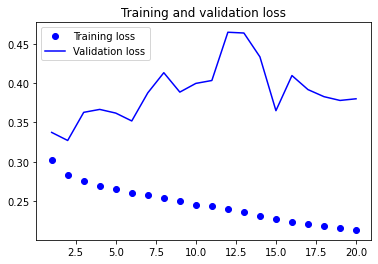

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We can see from curves that model is overfitting thus lacking generalization

Using Recurrent dropout to fight overfitting

In [ ]:
from keras import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
#compiling model
model.compile(optimizer = RMSprop(),loss = "mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 40,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/40
500/500 [==============================] - 126s 252ms/step - loss: 0.3409 - val_loss: 0.0967
Epoch 2/40
500/500 [==============================] - 126s 252ms/step - loss: 0.3062 - val_loss: 0.1206
Epoch 3/40
500/500 [==============================] - 127s 254ms/step - loss: 0.2991 - val_loss: 0.1445
Epoch 4/40
500/500 [==============================] - 127s 254ms/step - loss: 0.2958 - val_loss: 0.1320
Epoch 5/40
500/500 [==============================] - 126s 252ms/step - loss: 0.2939 - val_loss: 0.1618
Epoch 6/40
500/500 [==============================] - 126s 253ms/step - loss: 0.2903 - val_loss: 0.1806
Epoch 7/40
500/500 [==============================] - 126s 251ms/step - loss: 0.2860 - val_loss: 0.1996
Epoch 8/40
500/500 [==============================] - 127s 253ms/step - loss: 0.2851 - val_loss: 0.2194
Epoch 9/40
500/500 [==============================] - 126s 252ms/step - loss: 0.2831 - val_loss: 0.2289
Epoch 10/40
500/500 [==============================] - 126s 252m

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


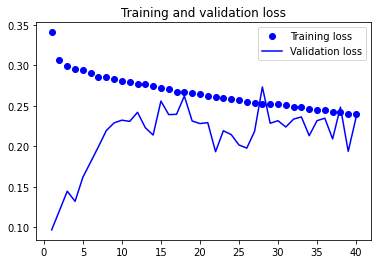

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The graph shows that we are no longer overfitting but we have hit a performance bottle neck and we have to increase model complexity

Training and evaluating a dropout-regularized,stacked GRU model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,dropout=0.1,recurrent_dropout=0.5,return_sequences=True,input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',dropout=0.1,recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=200,      #500
                              epochs=10,               #40
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
200/200 [==============================] - 214s 1s/step - loss: 0.3374 - val_loss: 0.2956
Epoch 2/10
200/200 [==============================] - 213s 1s/step - loss: 0.3130 - val_loss: 0.2763
Epoch 3/10
200/200 [==============================] - 209s 1s/step - loss: 0.3073 - val_loss: 0.2831
Epoch 4/10
200/200 [==============================] - 208s 1s/step - loss: 0.3033 - val_loss: 0.2772
Epoch 5/10
200/200 [==============================] - 209s 1s/step - loss: 0.3011 - val_loss: 0.2758
Epoch 6/10
200/200 [==============================] - 210s 1s/step - loss: 0.2965 - val_loss: 0.2709
Epoch 7/10
200/200 [==============================] - 210s 1s/step - loss: 0.2927 - val_loss: 0.2773
Epoch 8/10
200/200 [==============================] - 210s 1s/step - loss: 0.2912 - val_loss: 0.2835
Epoch 9/10
200/200 [==============================] - 210s 1s/step - loss: 0.2906 - val_loss: 0.2666
Epoch 10/10
200

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 32)          4608      
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                18816     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 23,489
Trainable params: 23,489
Non-trainable params: 0
_________________________________________________________________


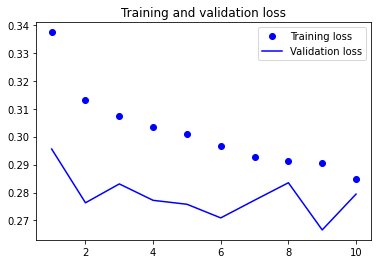

In [12]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

**Using Bi-directional RNN's**

In [14]:
#Writing a Python Generator  It yields a tuple (samples, targets),where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
#data,lookback,delay,min_index,max_index,shuffle,batch_size,step
def reverse_order_generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None: 
        max_index = len(data) - delay - 1 
    i = min_index + lookback 
    while 1:
        if shuffle: 
            #Generate random rows
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index: 
                i = min_index + lookback    
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows) # 
        samples = np.zeros((len(rows),lookback // step,data.shape[-1])) 
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets    #the step which shuffle the time steps
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)        

In [16]:
model = Sequential()
model.add(layers.GRU(32,
                     dropout = 0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
#compiling model
model.compile(optimizer = RMSprop(),loss = "mae")

history = model.fit_generator(train_gen,
                              steps_per_epoch = 500,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

Epoch 1/20
500/500 [==============================] - 93s 185ms/step - loss: 0.3275 - val_loss: 0.2757
Epoch 2/20
500/500 [==============================] - 94s 187ms/step - loss: 0.3053 - val_loss: 0.2781
Epoch 3/20
500/500 [==============================] - 93s 185ms/step - loss: 0.2976 - val_loss: 0.2815
Epoch 4/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2938 - val_loss: 0.2720
Epoch 5/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2877 - val_loss: 0.2764
Epoch 6/20
500/500 [==============================] - 96s 192ms/step - loss: 0.2838 - val_loss: 0.2720
Epoch 7/20
500/500 [==============================] - 95s 190ms/step - loss: 0.2805 - val_loss: 0.2767
Epoch 8/20
500/500 [==============================] - 94s 188ms/step - loss: 0.2769 - val_loss: 0.2738
Epoch 9/20
500/500 [==============================] - 95s 189ms/step - loss: 0.2710 - val_loss: 0.2774
Epoch 10/20
500/500 [==============================] - 95s 189ms/step - l

In [17]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


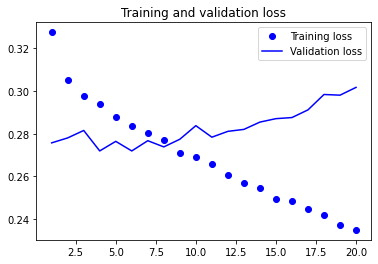

In [18]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Training and evaluating a bidirectional network

In [21]:
model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/10
300/300 [==============================] - 113s 376ms/step - loss: 0.3074 - val_loss: 0.2736
Epoch 2/10
300/300 [==============================] - 112s 373ms/step - loss: 0.2797 - val_loss: 0.2711
Epoch 3/10
300/300 [==============================] - 112s 373ms/step - loss: 0.2763 - val_loss: 0.2807
Epoch 4/10
300/300 [==============================] - 111s 370ms/step - loss: 0.2698 - val_loss: 0.2602
Epoch 5/10
300/300 [==============================] - 113s 377ms/step - loss: 0.2669 - val_loss: 0.2642
Epoch 6/10
300/300 [==============================] - 112s 373ms/step - loss: 0.2639 - val_loss: 0.2651
Epoch 7/10
300/300 [==============================] - 111s 371ms/step - loss: 0.2608 - val_loss: 0.2662
Epoch 8/10
300/300 [==============================] - 111s 371ms/step - loss: 0.2588 - val_loss: 0.2695
Epoch 9/10
300/300 [==============================] - 113s 376ms/step - loss: 0.2544 - val_loss: 0.2670
Epoch 10/10
300/300 [==============================] - 112s 372m

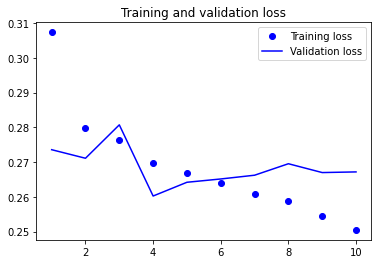

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

It performs about as well as the regular GRU layer. It's easy to understand why: all of the predictive capacity must be coming from the chronological half of the network, since the anti-chronological half is known to be severely underperforming on this task 

**Things learnt**


*   As I first learned in Chapter 4, when approaching a new problem, it is good to first establish common sense baselines for your metric of choice. If I don't have a baseline to beat, I can't tell if you are making any real progress.
*   Try simple models before expensive ones, to justify the additional expense. Sometimes a simple model will turn out to be your best option.
*   On data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.
*   To use dropout with recurrent networks, one should use a time-constant dropout mask and recurrent dropout mask. This is built into Keras recurrent layers, so all you have to do is use the dropout and recurrent_dropout arguments of recurrent layers.
*   Stacked RNNs provide more representational power than a single RNN layer. They are also much more expensive, and thus not always worth it. While they offer clear gains on complex problems (e.g. machine translation), they might not always be relevant to smaller, simpler problems.
*   Bidirectional RNNs, which look at a sequence both ways, are very useful on natural language processing problems. However, they will not be strong performers on sequence data where the recent past is much more informative than the beginning of the sequence.


